# Часть 1. Проверка гипотезы в Python и составление аналитической записки

- Автор: Игнатьев Валерий
- Дата: 30.11.2025

## Цели и задачи проекта

**Цель:**
Статистически проверить гипотезу о том, что пользователи из Санкт‑Петербурга проводят в среднем больше времени за чтением и прослушиванием книг в приложении, чем пользователи из Москвы.

**Задачи:**

- Проверить качество данных.

- Сравнить размеры и базовые статистики групп.

- Провести односторонний t‑тест для независимых выборок.

- Интерпретировать результаты и сформулировать выводы.


## Описание данных

Данные находятся в датафрейме `/datasets/yandex_knigi_data.csv`

* `city` - Город пользователя
* `puid` - Id пользователя
* `hours` - Суммарное кол-во часов прослушивания

## Содержимое проекта

- Загрузка данных и знакомство с ними. Проверка данных на дубликаты и пропуски
- Сравнение данных между двумя группами и их распределения
- Проверка гипотезы. Проведение статистических тестов (t-test Уэлча и тест Мана-Уитни)
- Интерпретация результатов, выводы и возможные причины получения результатов

## 1. Загрузка данных и знакомство с ними

Загрузим данные пользователей из Москвы и Санкт-Петербурга c их активностью (суммой часов чтения и прослушивания) из файла `/datasets/yandex_knigi_data.csv` и изучим их.

In [1]:
# Импортируем необходимые библиотеки
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind, mannwhitneyu

from statsmodels.stats.proportion import proportion_effectsize
from statsmodels.stats.power import NormalIndPower
from statsmodels.stats.proportion import proportions_ztest

In [2]:
# Загружаем DF
books_df = pd.read_csv('https://code.s3.yandex.net/datasets/yandex_knigi_data.csv')

In [3]:
# Познакомимся с данными
books_df.sample(3)

,Unnamed: 0,city,puid,hours
4262,4262,Москва,1361794920,2.030459
1663,1663,Москва,341438831,0.220521
2752,2752,Москва,732236948,23.371944


In [4]:
# Изучим колонки DF
books_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8784 entries, 0 to 8783
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  8784 non-null   int64  
 1   city        8784 non-null   object 
 2   puid        8784 non-null   int64  
 3   hours       8784 non-null   float64
dtypes: float64(1), int64(2), object(1)
memory usage: 274.6+ KB


* Данные целостны и не содержат Null значений
* В данных 8784 записи и 4 колонки

In [5]:
# Уберем ненужный столбец
books_df.drop('Unnamed: 0', axis=1, inplace=True)

In [6]:
# Проверим явные дубликаты
books_df.duplicated().sum()

0

In [7]:
# Проверим неявные дубликаты по puid
books_df.duplicated(subset='puid').sum()

244

In [8]:
# Проверим дубликаты
display(books_df[books_df.duplicated(subset='puid', keep=False)].sort_values('puid').head())

# Проверим дубликаты на различные города
puid_city_count = books_df.groupby('puid')['city'].nunique()
dublicated_id = puid_city_count[puid_city_count > 1].shape[0]
display(f'Дублируется puid в двух разных городах - {dublicated_id}')
display(f'Доля дубликатов в данных - {round(dublicated_id/ books_df.shape[0],2)*100}%')

,city,puid,hours
35,Москва,2637041,10.317371
6247,Санкт-Петербург,2637041,3.883926
134,Москва,9979490,32.415573
6274,Санкт-Петербург,9979490,1.302997
145,Москва,10597984,42.931506


'Дублируется puid в двух разных городах - 244'

'Доля дубликатов в данных - 3.0%'

* Все 244 неявных дубликата по id пользователя пренадлежат двум разным городам.
* Дубликаты составляют 3% от всех данных, можем их просто удалить

In [9]:
# Проведем удаление дубликатов
books_df.drop_duplicates(subset=['puid'], keep=False, inplace=True)

In [10]:
books_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8296 entries, 0 to 8783
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   city    8296 non-null   object 
 1   puid    8296 non-null   int64  
 2   hours   8296 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 259.2+ KB


**Выводы:**
* После предобработки данных в финальном DF осталось 8296 записей с уникальными ID пользователей
* Было удалено 244 неявных дубликата с одинаковым puid, но разными городами. Доля этих дубликатов составила 3% от исходного размера DF
* Данные подготовлены и можно приступать к проверке гипотезы

## 2. Проверка гипотезы в Python

Сформулируем гипотезу и проверим ее через статистические тесты:

* Нулевая гипотеза $H_0: \mu_{\text{СПб}} \leq \mu_{\text{Москва}}$ <br> Среднее время активности пользователей в Санкт-Петербурге не больше, чем в Москве.

* Альтернативная гипотеза $H_1: \mu_{\text{СПб}} > \mu_{\text{Москва}}$ <br> Среднее время активности пользователей в Санкт-Петербурге больше, и это различие статистически значимо.

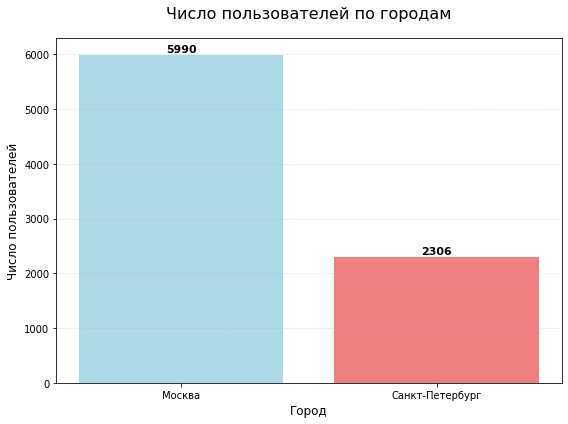

In [11]:
# Проверим распределение пользователей между группами
group_info = books_df.groupby('city')['puid'].nunique().reset_index().rename(columns={'puid': 'users'})

# Строим график
plt.figure(figsize=(8, 6))
plt.bar(group_info['city'], group_info['users'], color=['lightblue', 'lightcoral'])

plt.title('Число пользователей по городам', fontsize=16, pad=20)
plt.xlabel('Город', fontsize=12)
plt.ylabel('Число пользователей', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)


for i, v in enumerate(group_info['users']):
    plt.text(i, v + 10, str(v), ha='center', va='bottom', fontsize=11, fontweight='bold')


plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

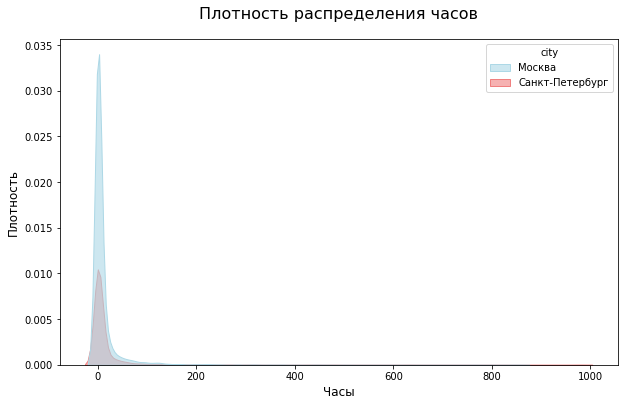

In [12]:
# Изучим распределение данных в двух группах
plt.figure(figsize=(10, 6))
sns.kdeplot(data=books_df, x='hours', hue='city', fill=True, alpha=0.6, palette=['lightblue', 'lightcoral'])
plt.title('Плотность распределения часов', fontsize=16, pad=20)
plt.xlabel('Часы', fontsize=12)
plt.ylabel('Плотность', fontsize=12)
plt.show()

In [13]:
# Разделим пользователей на два DF с городами
moscow_df = books_df[books_df['city'] == 'Москва']['hours']
spb_df = books_df[books_df['city'] == 'Санкт-Петербург']['hours']

In [14]:
# Изучим основные показатели группы
moscow_df.describe()

count    5990.000000
mean       10.848192
std        36.925622
min         0.000022
25%         0.057042
50%         0.888232
75%         5.933439
max       857.209373
Name: hours, dtype: float64

In [15]:
# Изучим основные показатели группы
spb_df.describe()

count    2306.000000
mean       11.264433
std        39.831755
min         0.000025
25%         0.060173
50%         0.875355
75%         6.138424
max       978.764775
Name: hours, dtype: float64

In [16]:
# Сравним средние значения между группами
a_mean = moscow_df.mean().item()
b_mean = spb_df.mean().item()
f"Среднее значение сессий в день для Москвы {a_mean}, для группы Санкт-Петербурга {b_mean}, различие {round(b_mean/a_mean - 1,2) *100}%"

'Среднее значение сессий в день для Москвы 10.84819150713916, для группы Санкт-Петербурга 11.264433367029522, различие 4.0%'

Проанализировав выборки, распределение и средние значения, можно сделать выводы:
* Выборки в двух группах сильно различаются (Москва - 5990 пользователей, Санкт-Петербург - 2306 пользователей)
* Распределение близко к нормальному, но имеет тяжелые хвосты
* Различие между выборочными средними 4% (В СПБ на 4% больше)

* Проведем T-TEST Уэлча и тест Мана-Уитни для сравнения и более точного анализа стат значимости
* Установим уровень стат значимости 0.05

In [17]:
# T-TEST Уэлча

alpha = 0.05

stat_welch_ttest, p_value_welch_ttest = ttest_ind(
    moscow_df, 
    spb_df, 
    equal_var=False,
    alternative='less'
)
if p_value_welch_ttest>alpha:
    print(f'p-value теста Уэлча ={round(p_value_welch_ttest, 2)}')
    print('Нулевая гипотеза находит подтверждение! Выборочные средние в группах A и B равны')
else:
    print(f'p-value теста Уэлча ={round(p_value_welch_ttest, 2)}')
    print('Нулевая гипотеза не находит подтверждения! Выборочные средние в группах A и B не равны, и в группе B больше')

p-value теста Уэлча =0.33
Нулевая гипотеза находит подтверждение! Выборочные средние в группах A и B равны


In [18]:
# Мана-Уитни
mw_test = mannwhitneyu(
    moscow_df,
    spb_df,
    alternative='less'
)

if mw_test.pvalue > alpha:
    print(f'p-value теста Мана-Уитни ={mw_test.pvalue} > {alpha}')
    print('Нулевая гипотеза находит подтверждение! Распределения метрики в группах A и B равны')
else:
    print(f'p-value теста Мана-Уитни ={mw_test.pvalue} < {alpha}')
    print('Нулевая гипотеза не находит подтверждения! Распределения метрики в группах A и B различаются')

p-value теста Мана-Уитни =0.4532273739367588 > 0.05
Нулевая гипотеза находит подтверждение! Распределения метрики в группах A и B равны


## 3. Аналитическая записка
По результатам анализа данных можно сделать выводы:

- Для эксперемента был установлен уровень стат значимости 0.05 и были проведены два теста (T-test уэлча и Мана-Уитни)

- Распределенеие средних часов просмотра и выборочные средние между группами равны. Различия не являются статистически значимыми. P-value t-test - 0.33, mw-test - 0.45

- По результатам двух тестов, P-value оказался больше чем уровень статистической значимости теста, поэтому можно предположить, что нулевая гипотеза о равенстве средних между Москвой и Санкт-Петербургом находит подтверждение.

- Возможные причины полученных результатов:
    * Отсутствие различий в поведении пользователей. Два города - мегаполисы со схожим ритмом жизни, они демонстрируют одинаковый паттерн поведения, тем самым различия между средними незначительные.
    * Недостаточность данных. Различия в кол-ве пользователей между выборками и недостаточный объем выборок могли повлиять на результаты тестов и различия могли быть не обнаруженны из-за недостаточного кол-ва данных.

----

# Часть 2. Анализ результатов A/B-тестирования

## 1. Цель исследования.



К нам обратились представители интернет магазина BitMotion Kit, в котором продаются геймифицированные товары для тех, кто ведёт здоровый образ жизни.  Интерфейс онлайн-магазина слишком сложен для пользователей — об этом говорят отзывы.

Чтобы привлечь новых клиентов и увеличить число продаж, владельцы магазина разработали новую версию сайта и протестировали его на части пользователей. По задумке, это решение доказуемо повысит количество пользователей, которые совершат покупку.

**Цель:** Необходимо провести оценку результата A/B тестирования нового интерфейса продукта и сделать выводы о данном исследовании.

## Описание данных

* `datasets/ab_test_participants.csv` — таблица участников тестов.

    * `user_id` — идентификатор пользователя;
    * `group` — группа пользователя;
    * `ab_test` — название теста;
    * `device` — устройство, с которого происходила регистрация.
    

* `datasets/ab_test_events.zip` — архив с одним csv-файлом, в котором собраны события 2020 года;

    * `user_id` — идентификатор пользователя;
    * `event_dt` — дата и время события;
    * `event_name` — тип события;
    * `details` — дополнительные данные о событии.


## Содержимое проекта
- Загрузка данных и знакомство с ними
- Корректность проведение теста и соответствие требованиям технического задания
- Анализ основных метрик теста между группами
- Расчет и анализ необходимой выборки для корректного теста
- Расчет основных статистик и проведение Z-теста
- Интерпретация результатов

## 2. Загрузим данные, оценим их целостность.


In [19]:
# Загружаем DF A/B тестирования
participants = pd.read_csv('https://code.s3.yandex.net/datasets/ab_test_participants.csv')
events = pd.read_csv('https://code.s3.yandex.net/datasets/ab_test_events.zip',
                     parse_dates=['event_dt'], low_memory=False)

In [20]:
# Изучим структуру DF
participants.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14525 entries, 0 to 14524
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  14525 non-null  object
 1   group    14525 non-null  object
 2   ab_test  14525 non-null  object
 3   device   14525 non-null  object
dtypes: object(4)
memory usage: 454.0+ KB


In [21]:
participants.head()

,user_id,group,ab_test,device
0,0002CE61FF2C4011,B,interface_eu_test,Mac
1,001064FEAAB631A1,B,recommender_system_test,Android
2,001064FEAAB631A1,A,interface_eu_test,Android
3,0010A1C096941592,A,recommender_system_test,Android
4,001E72F50D1C48FA,A,interface_eu_test,Mac


**Выводы:**
* Датафрейм содержит 14 525 строк и не содержит пропусков
* В датафрейме содержится информация о двух тестах interface_eu_test и recommender_system_test. Далее оставим только интересующий нас тест - interface_eu_test.

In [22]:
# Изучим структуру DF
events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 787286 entries, 0 to 787285
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   user_id     787286 non-null  object        
 1   event_dt    787286 non-null  datetime64[ns]
 2   event_name  787286 non-null  object        
 3   details     249022 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 24.0+ MB


In [23]:
events.head()

,user_id,event_dt,event_name,details
0,GLOBAL,2020-12-01 00:00:00,End of Black Friday Ads Campaign,ZONE_CODE15
1,CCBE9E7E99F94A08,2020-12-01 00:00:11,registration,0.0
2,GLOBAL,2020-12-01 00:00:25,product_page,NaN
3,CCBE9E7E99F94A08,2020-12-01 00:00:33,login,NaN
4,CCBE9E7E99F94A08,2020-12-01 00:00:52,product_page,NaN


**Выводы:**
* Датафрейм содержит 787 286 записей.
* Пропуски встречаются в колонке details - данные Nan значения можно не обрабатывать, т.к значения этой колонки нас не интересуют. Пропуски могут быть связаны с отсутствием дополнительных данных о событии.
* В датафрейме содержатся значения Global в user_id. Необходимо более детально их изучить.

In [24]:
# Изучим строчки с этими значениями
events[events['user_id'] == "GLOBAL"].sample(10)

,user_id,event_dt,event_name,details
679598,GLOBAL,2020-12-24 20:51:21,product_cart,NaN
26713,GLOBAL,2020-12-04 01:56:48,product_page,NaN
258803,GLOBAL,2020-12-13 03:47:36,product_page,NaN
113521,GLOBAL,2020-12-08 09:20:44,product_page,NaN
186803,GLOBAL,2020-12-10 22:21:23,product_page,NaN
176099,GLOBAL,2020-12-10 13:45:06,product_page,NaN
463460,GLOBAL,2020-12-18 18:47:03,product_cart,NaN
2795,GLOBAL,2020-12-01 07:44:34,product_page,NaN
447790,GLOBAL,2020-12-18 06:59:39,product_page,NaN
568687,GLOBAL,2020-12-21 15:56:17,purchase,4.99


In [25]:
# Изучим долю этих значений
glob_v = events[events['user_id'] == "GLOBAL"].shape[0]
glob_share = round(glob_v/events.shape[0],2)
print(f'Значений GLOBAL в DF - {glob_v} их доля от общего кол-ва записей - {glob_share}')

Значений GLOBAL в DF - 58495 их доля от общего кол-ва записей - 0.07


In [26]:
# Проверим эти значения в датафрейме A/B тестирований
participants[participants['user_id'] == "GLOBAL"]

,user_id,group,ab_test,device


**Вывод:**
* Значения GLOBAL занимают 7% от всего объема датафрейма. Данный user_id отсутствует в датасете A/B тестирования и никак не повлияет на результаты. Данное значение может быть системным событием, которое не связано с пользователем (например - End of Black Friday Ads Campaign)
* В дальнейшем, при извлечении пользователей A/B тестирования эти значения пропадут и не повлияют на эксперемент.

## 3. По таблице `ab_test_participants` оценим корректность проведения теста:

   3\.1 Выделим пользователей, участвующих в тесте, и проверим

   - соответствие требованиям технического задания,

   - равномерность распределения пользователей по группам теста,

   - отсутствие пересечений с конкурирующим тестом (нет пользователей, участвующих одновременно в двух тестовых группах).

Гипотеза аналитика заключается в следующем: *упрощение интерфейса приведёт к тому, что в течение семи дней после регистрации в системе конверсия зарегистрированных пользователей в покупателей увеличится как минимум на три процентных пункта.*

Данная гипотеза соответствует принципу A/B тестирования. У нее есть четкая формулировка, сроки и KPI который мы отслеживаем. Нулевая гипотеза подразумевает отсутствие изменений между метриками.

Изучим данные более детально и проверим их корректность.

In [27]:
# Оставим пользователей, которые участвовали в тесте interface_eu_test
interface_eu_test = participants[participants['ab_test'] == 'interface_eu_test']
interface_eu_test.shape[0]

10850

Из исходного DF 10 850 записей пренадлежат к интересующему нас A/B тестированию

In [28]:
# Проверим пересекающихся пользователей
group_count = interface_eu_test.groupby('user_id')['group'].nunique()
dublicated_id = group_count[group_count > 1].shape[0]
print(f'Id дублируется в разных группах A/B - {dublicated_id}')

Id дублируется в разных группах A/B - 0


Повторяющихся участников между группами не найдено

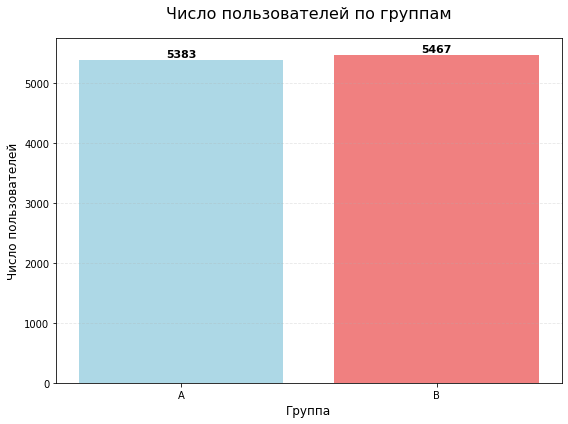

In [29]:
# Изучим распределение пользователей по группам A/B
group_info = interface_eu_test.groupby('group')['user_id'].nunique().reset_index().rename(columns={'user_id': 'users'})

# Строим график
plt.figure(figsize=(8, 6))
plt.bar(group_info['group'], group_info['users'], color=['lightblue', 'lightcoral'])

plt.title('Число пользователей по группам', fontsize=16, pad=20)
plt.xlabel('Группа', fontsize=12)
plt.ylabel('Число пользователей', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)


for i, v in enumerate(group_info['users']):
    plt.text(i, v + 10, str(v), ha='center', va='bottom', fontsize=11, fontweight='bold')


plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

In [30]:
# Проверим разницу между группами
A = group_info[group_info["group"] == 'A']['users'].item()
B = group_info[group_info["group"] == 'B']['users'].item()
P = 100*((abs(A - B))/A)
f"Процентная разница между группами {P:.2f}%"

'Процентная разница между группами 1.56%'

In [31]:
# Проверим распределение пользователей по типам устройств

group_A = interface_eu_test[interface_eu_test['group'] == 'A']
group_B = interface_eu_test[interface_eu_test['group'] == 'B']

group_A_device = group_A.groupby('device')['user_id'].nunique().reset_index().rename(columns={'user_id': 'users'})
group_B_device = group_B.groupby('device')['user_id'].nunique().reset_index().rename(columns={'user_id': 'users'})
group_A_device['share %'] = round(group_A_device['users']/group_A_device['users'].sum() *100,2)
group_B_device['share %'] = round(group_B_device['users']/group_B_device['users'].sum() *100,2)

In [32]:
# Создаем функцию для графиков
def plot_barh_with_shares(df, x_value, share_value,  title, x_label, color_g, size=(12, 5)):
    
    df_sorted = df.sort_values(by=share_value)
    
    ax = df_sorted.plot.barh(
        x=x_value, 
        y=share_value,
        legend=False, 
        color=color_g, 
        figsize=size
    )
    
  
    for i, value in enumerate(df_sorted[share_value]):
        ax.text(
            value, 
            i, 
            f'{value:.2f}%', 
            va='center', 
            ha='left', 
            color='black',
            fontsize=10
        )

    
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    
    plt.ylabel('')
    plt.title(title, fontsize=15, pad=20, fontweight='bold')
    plt.xlabel(x_label, labelpad=15)
    
    return plt

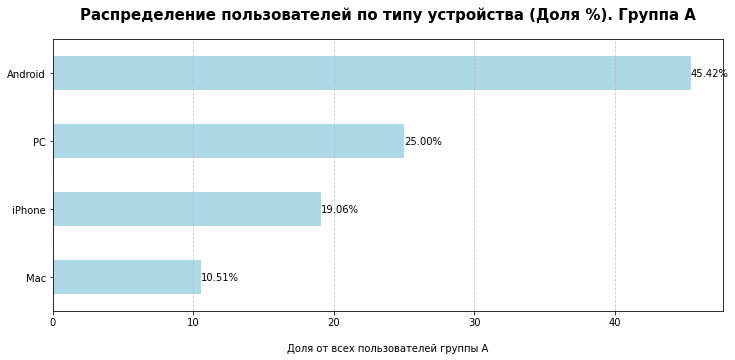

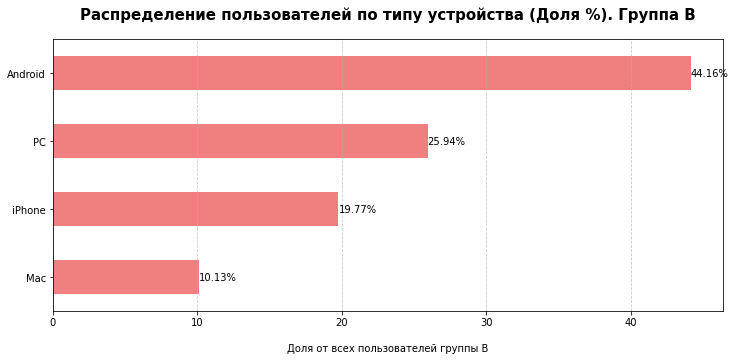

In [33]:
plt_a = plot_barh_with_shares(group_A_device, 'device','share %',  'Распределение пользователей по типу устройства (Доля %). Группа A', 'Доля от всех пользователей группы A', 'lightblue')
plt_b = plot_barh_with_shares(group_B_device, 'device','share %',  'Распределение пользователей по типу устройства (Доля %). Группа B', 'Доля от всех пользователей группы B', 'lightcoral')
plt_a.show()
plt_b.show()

**Выводы:**
* Из исходного датафрейма (14 525 записей) - 10 850 записей пренадлежат к интересующему нас A/B тестированию;
* Распределение участников между группами в пределах нормы. Различие между кол-вом участников - 1.6%;
* Пользователей, которые состоят в двух группах не найдено;
* Распределение пользователей по типу устройств между группами примерно одинаковое;

3\.2 Проанализируем данные о пользовательской активности по таблице `ab_test_events`:

Оставим только события, связанные с участвующими в изучаемом тесте пользователями;

In [34]:
# Оставим события для участников A/B теста
a_b_events = events.merge(interface_eu_test, on='user_id')
a_b_events.shape[0]

79715

Определим горизонт анализа: рассчитаем время (лайфтайм) совершения события пользователем после регистрации и оставим только те события, которые были выполнены в течение первых семи дней с момента регистрации

In [35]:
# Получим все события для пользователей в первые 7 дней с момента регистрации
reg_date = a_b_events[a_b_events['event_name'] == 'registration'][['user_id', 'event_dt']]
reg_date['event_dt_date'] = reg_date['event_dt'].dt.date
reg_date['lifetime'] = reg_date['event_dt'] + pd.Timedelta(days=7)

a_b_events_with_lifetime = a_b_events.merge(reg_date[['user_id', 'lifetime']], on='user_id', how='left')
actual_df = a_b_events_with_lifetime[a_b_events_with_lifetime['event_dt'].dt.date <= a_b_events_with_lifetime['lifetime']]

actual_df.shape[0]

70102

Основные параметры теста:
* Базовый показатель конверсии 30%
* Мощность теста 0.8
* Вероятность ошибки второго рода — 0.2
* Уровень значимости — 0.05
* MDE - 0.03

In [36]:
# Задаём параметры
alpha = 0.05
beta = 0.2
power = 0.8
p = 0.3
mde = 0.03
effect_size = proportion_effectsize(p, p + mde)

# Инициализируем класс NormalIndPower
power_analysis = NormalIndPower()

# Рассчитываем размер выборки
sample_size = power_analysis.solve_power(
    effect_size = effect_size,
    power = power,
    alpha = alpha,
    ratio = 1 # Равномерное распределение выборок
)

print(f"Необходимый размер выборки для каждой группе: {int(sample_size)}")

Необходимый размер выборки для каждой группе: 3761


В данном эксперементе необходимый размер выборки соблюдается в двух группах

Рассчитаем для каждой группы количество посетителей, сделавших покупку, и общее количество посетителей.

In [37]:
# Расчитаем пользователей которые совершили покупку и конверсию в покупку для групп
group_a = actual_df[actual_df["group"] == 'A']
group_b = actual_df[actual_df["group"] == 'B']

n_a = group_a['user_id'].nunique()
n_b = group_b['user_id'].nunique()

m_a = group_a[group_a['event_name'] == 'purchase']['user_id'].nunique()
m_b = group_b[group_b['event_name'] == 'purchase']['user_id'].nunique()

p_a = m_a/n_a
p_b = m_b/n_b



print(f'Конверсия в покупку группы A - {round(p_a, 2)}, группы B - {round(p_b, 2)}. Разница между конверсией {round(p_b-p_a,2)}')

Конверсия в покупку группы A - 0.28, группы B - 0.3. Разница между конверсией 0.02


**Вывод:**
* Необходимая выбока для каждой группы - 3 761. Эта выборка соблюдается в A/B тестировании
* Конверсия в покупку между группами различается на 2п.п.. Вторая группа показывает большую конверсию -30%, в то время как первая показывает 28%. Ожидаемое изменение в 3 п.п. не достигнуто. В данный момент разница в 2%. Необходимо провести статтест для оценки уровня значимости

## 4. Проведем оценку результатов A/B-тестирования:

Гипотезы для проверки:

* **Нулевая гипотеза  𝐻0:𝜇B≤𝜇A**
    
    Конверсия в покупку для группы B не больше, чем для группы A
    
    
* **Альтернативная гипотеза  𝐻1:𝜇B>𝜇A**
    
    Конверсия для группы B больше, и это различие статистически значимо.

Проверим изменение конверсии через Z-test пропорций

In [38]:
# Проводим Z-тест пропорций

# Проверим достаточное кол-во данных
if (p_a*n_a > 10)and((1-p_a)*n_a > 10)and(p_b*n_b > 10)and((1-p_b)*n_b > 10):
    print('Предпосылка о достаточном количестве данных выполняется!')
else:
    print('Предпосылка о достаточном количестве данных НЕ выполняется!')
  

# Стат тест
alpha = 0.05

stat_ztest, p_value_ztest = proportions_ztest(
    [m_a, m_b],
    [n_a, n_b],
    alternative='smaller'
)


if p_value_ztest > alpha:
    print(f'pvalue={p_value_ztest} > {alpha}')
    print('Нулевая гипотеза находит подтверждение!')
else:
    print(f'pvalue={p_value_ztest} < {alpha}')
    print('Нулевая гипотеза не находит подтверждения!')

Предпосылка о достаточном количестве данных выполняется!
pvalue=0.017720224409103865 < 0.05
Нулевая гипотеза не находит подтверждения!


**Выводы после A/B тестирования:**

* Полученный p‑value = 0,0177 позволяет отвергнуть нулевую гипотезу об отсутствии разницы между группами. Рост коверсии в покупку для группы B - статистически значим;
* Новый интерфейс демонстрирует улучшение показателей конверсии по сравнению с текущим решением;
* Наблюдаемое различие между группами составило только 2 процентных пункта, что ниже целевого порога 3%.
* После проведенного A/B-тестирования конверсия показывает статистически значимый рост, но не достигает целевого порога. Можно более внимательно изучить этот порог в 3 п.п., и если это строгая цифра — добавить дополнительные обновления к интерфейсу. Еслиже порог в 2% допустим и покажет прирост выручки, на который рассчитывает компания, то можно вводить новый интерфейс для всех пользователей.